### mDA neuron screen

Imports

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Determine hits based on Mahalanobis (SD) threshold and toxicity threshold

In [7]:
df  = pd.read_csv('after_classification_mahalanobis_distances_normalized.csv')

# Dropping the rows of unwanted plates and fluorescent compounds
df = df[df['Plate'].str.contains('PD-SC2-01') == False]
df = df[df['tags'].str.contains('Terthiophene|Rhodamine B|Obatoclax Mesylate') == False]

# Extract DMSO controls only
df_mut_dmso = df[df['tags'].str.contains('Mut;DMSO')]

# Calculate DMSO medians per plate 
df_median = df_mut_dmso.groupby(df_mut_dmso['Plate']).median().reset_index().add_suffix('_median')
df_median = df_median.rename(columns={'Plate_median': "Plate"})

# Calculate DMSO SDs per plate 
df_std = df_mut_dmso.groupby(df_mut_dmso['Plate']).std().reset_index().add_suffix('_std')
df_std = df_std.rename(columns={'Plate_std': "Plate"})

# Merge median and std values
df_median_std = pd.merge(df_median[['Plate','Nuclei_Number_Living_median', 'Cell_Neurites_LengthPerNuclei_MAP2_median']],
                         df_std[['Plate','Nuclei_Number_Living_std', 'Cell_Neurites_LengthPerNuclei_MAP2_std']],
                         on='Plate', how='left')
# Join medians and SDs per plate with all data
df = df.join(df_median_std.set_index('Plate'), on='Plate')

# Thresholds for toxcity selection
SD_nuclei_thresh = 3

# Calculate toxicity limits
limit_nuclei = df['Nuclei_Number_Living_median']-SD_nuclei_thresh*df['Nuclei_Number_Living_std'] 

# Apply toxicity limits to dataset
df_non_toxic = (df['Nuclei_Number_Living']>=limit_nuclei)
df = df.assign(non_toxic=df_non_toxic)

# Add label
df['exp_condition'] = np.where(df['tags'].isin(['Mut;DMSO','WT;DMSO','Mut;PRO']), df['tags'], 'Mut;Compound')

# Select only non toxic molecules
df_compounds = df[df.non_toxic]

# HIT SELECTION
# Remove controls
Search_for_These_values = ['DMSO','PRO'] 
pattern = '|'.join(Search_for_These_values)
df_compounds_noCtrls = df_compounds.loc[~df_compounds['tags'].str.contains(pattern, case=False)]
df_Ctrls_only = df_compounds.loc[df_compounds['tags'].str.contains(pattern, case=True)]
# Choose hits based on threshold
hit_selection_thresh = 4
df_pre_hits = df_compounds_noCtrls.loc[df_compounds_noCtrls['mahalanobis_from_neg'] > hit_selection_thresh]

# Drop all tags that occur only once
df_hits = df_pre_hits[df_pre_hits.duplicated(subset=['tags'], keep=False)]
df_hits_grouped = df_hits.groupby(['tags'], as_index=False).mean()

# Merge controls with hits
df_merged = pd.concat([df_Ctrls_only, df_hits], ignore_index=True)

# Save as .csv
df_merged.to_csv('All_primary_hits_and_controls.csv')
df_hits.to_csv('All_primary_hits.csv')
df_hits_grouped.to_csv('All_primary_hits_grouped_by_compound.csv')

C:\Users\JohannesWilbertz\AppData\Local\Temp\ipykernel_4488\128938588.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_median = df_mut_dmso.groupby(df_mut_dmso['Plate']).median().reset_index().add_suffix('_median')
C:\Users\JohannesWilbertz\AppData\Local\Temp\ipykernel_4488\128938588.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std = df_mut_dmso.groupby(df_mut_dmso['Plate']).std().reset_index().add_suffix('_std')
C:\Users\JohannesWilbertz\AppData\Local\Temp\ipykernel_4488\128938588.py:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future 

Plot data

C:\Users\JohannesWilbertz\AppData\Local\Temp\ipykernel_4488\1292845616.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compounds['exp_condition'] = np.where((df_compounds.tags == compound_of_interest),compound_of_interest,df_compounds.exp_condition)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


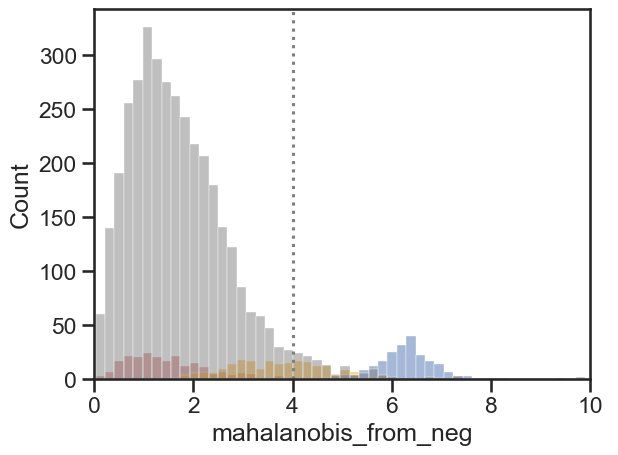

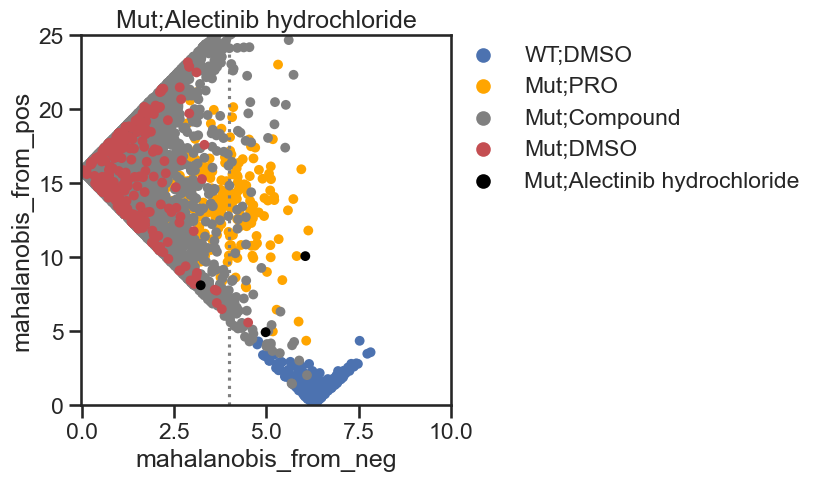

In [8]:
# PLOT DATA
# Define compound of interest
compound_of_interest = 'Mut;Alectinib hydrochloride'
df_compounds['exp_condition'] = np.where((df_compounds.tags == compound_of_interest),compound_of_interest,df_compounds.exp_condition)

sns.set_context("talk")
sns.set_style("ticks")

# Set colors
color_dict = dict({'WT;DMSO':'#4C72B0',
                  'Mut;Compound':'gray',
                  'Mut;DMSO':'#C44E52',
                  'Mut;PRO': 'orange',
                  compound_of_interest: 'black'})

hue_order=['WT;DMSO', 'Mut;PRO', 'Mut;Compound', 'Mut;DMSO', compound_of_interest]

# Plot histogram using Mahalanobis distances from negative control for all classes
ax = sns.histplot(data=df_compounds, x="mahalanobis_from_neg", hue="exp_condition", palette=color_dict)

# Figure aesthetics
ax.set_xlim(0, 10)
ax.axvline(x=hit_selection_thresh, ls=":", c="0.5")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., frameon=False)
plt.savefig('3-Class-LDA_Histplot_Compounds_Mahalanobis' + '.pdf', bbox_inches='tight')
plt.show()

# Plot Volcano plot using Mahalanobis distances
ax = sns.scatterplot(data=df_compounds.sort_values('exp_condition', key=np.vectorize(hue_order.index)), 
                     x='mahalanobis_from_neg' ,y='mahalanobis_from_pos', 
                     hue='exp_condition', s=50,
                     edgecolor='none', hue_order=hue_order, palette=color_dict)

# Figure aesthetics
ax.set_xlim(-0.01, 10)
ax.set_ylim(-0.01, 25)
ax.set_box_aspect(1)
ax.set_title(compound_of_interest)
ax.axvline(x=hit_selection_thresh, ls=":", c="0.5")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., frameon=False)
plt.savefig('3-Class-LDA_Volcano_Compounds_Mahalanobis' + '.pdf', bbox_inches='tight')
plt.show()